In [7]:
import numpy as np
from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend
from qilisdk.functionals import TimeEvolution
import matplotlib.pyplot as plt

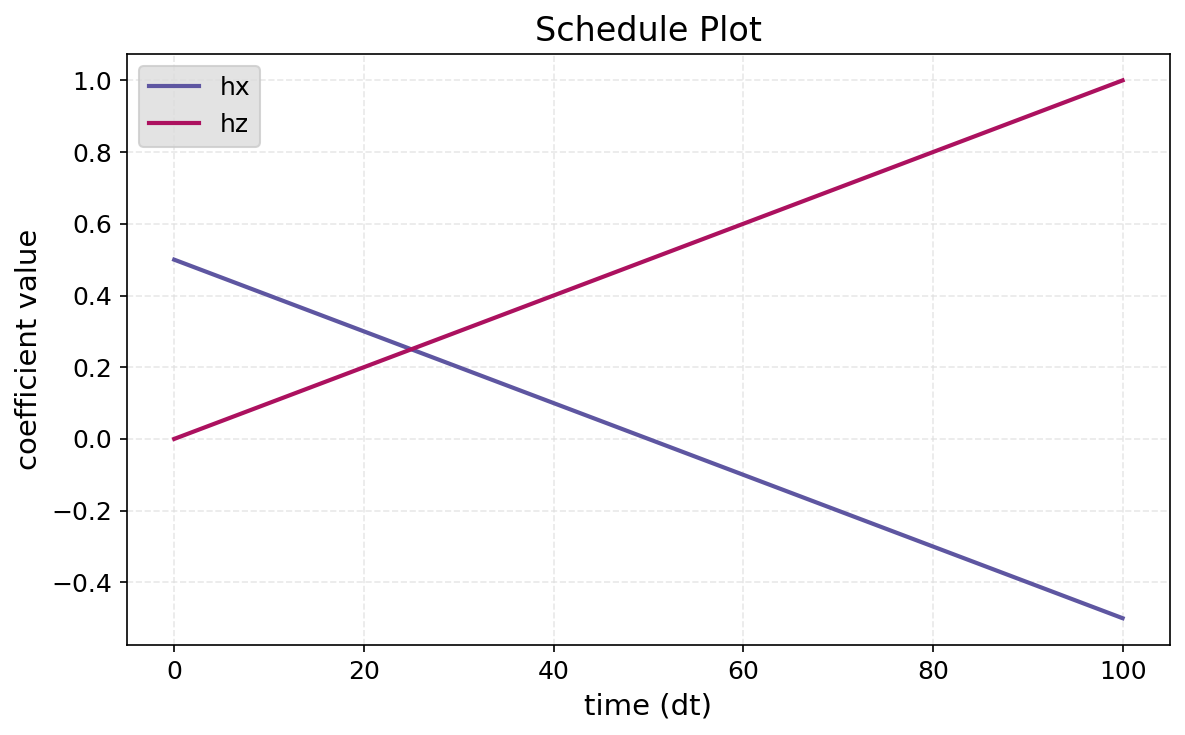

In [2]:
#System parameters
nqubits = 1
alpha = np.sqrt(8.)
epsilon = 1.

#Hamiltonians
Hx = alpha*X(0) + epsilon*Z(0)
Hz = epsilon*Z(0)

#Scheduler parameters
T = 100.0
dt = 0.1

# Build a time‑dependent schedule
schedule = Schedule(
    hamiltonians={"hx": Hx, "hz": Hz},
    coefficients={
        "hx": {(0.0, T): lambda t: 0.5 - t / T},
        "hz": {(0.0, T): lambda t: t / T},
    },
    dt=dt,
)

# draw the schedule
schedule.draw()

In [3]:
# Define total time and timestep
T = 100.0
dt = 0.1
nqubits = 1

# Define Hamiltonians
Hx = sum(X(i) for i in range(nqubits))
Hz = sum(Z(i) for i in range(nqubits))

# Build a time‑dependent schedule
schedule = Schedule(
    hamiltonians={"hx": Hx, "hz": Hz},
    coefficients={
        "hx": {(0.0, T): lambda t: 1 - t / T},
        "hz": {(0.0, T): lambda t: t / T},
    },
    dt=dt,
)

# draw the schedule
# schedule.draw()

# Prepare an equal superposition initial state
initial_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()

# Create the TimeEvolution functional
time_evolution = TimeEvolution(
    schedule=schedule,
    initial_state=initial_state,
    observables=[Z(0), X(0), Y(0)],
    nshots=100,
    store_intermediate_results=False,
)

# Execute on Qutip backend and inspect results
backend = QutipBackend()
results = backend.execute(time_evolution)
print(results)

TimeEvolutionResult(
  final_expected_values=array([-0.99998719,  0.00440282, -0.00249685]),
  final_state=QTensor(shape=2x1, nnz=2, format='csr')
[[-0.00253077+2.61136877e-07j]
 [-0.86980629+4.93386879e-01j]]
)


In [4]:
def H(a, e, t):
    sx = np.array([[1,0],[0,-1]])
    sz = np.array([[0,1],[1,0]])
    Hx = alpha*sx + epsilon*sz
    Hz = epsilon*sz
    H = t*Hz + (0.5 - t)*Hx
    return H

In [33]:
alpha = np.sqrt(8)
epsilon = 1
t_list = np.linspace(0, 1, 101)
g, e = [], []

for t in t_list:
    Ham = H(alpha, epsilon, t)
    eigvals, eigvecs = np.linalg.eigh(Ham)
    g.append(eigvals[0])
    e.append(eigvals[1])

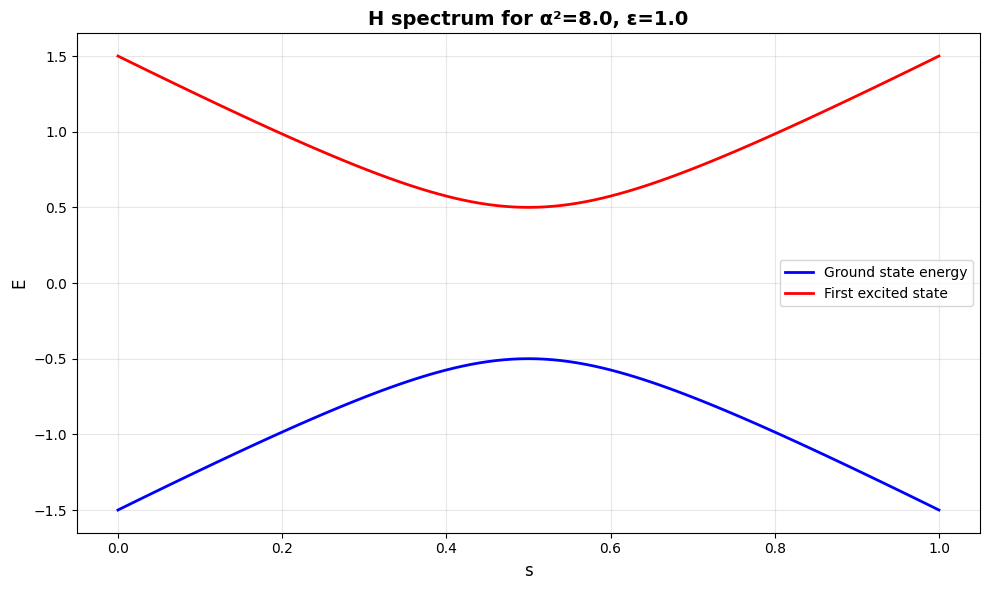

In [34]:
# Create plot
plt.figure(figsize=(10, 6))

# Plot each line
plt.plot(t_list, g, label='Ground state energy', linewidth=2, color='blue', linestyle='-')
plt.plot(t_list, e, label='First excited state', linewidth=2, color='red', linestyle='-')

# Customize
plt.title(f'H spectrum for α²={alpha**2:.1f}, ε={epsilon:.1f}', fontsize=14, fontweight='bold')
plt.xlabel('s', fontsize=12)
plt.ylabel('E', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Show
plt.tight_layout()
plt.show()